In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

sns.set_theme()

# Import buildbot nightly-value run 00437

In [2]:
data_dirty = pd.read_csv(filepath_or_buffer='./00437.-r_integration-nightly-value.2023-03-01_00-26-24.table.csv',sep='\t',header=2,index_col=0)

In [17]:
data_in = data_dirty.copy()

#Drop tasks with status TIMEOUT and unknown
# We cannot train on them, because we do not know the stats
# at the time when they would have finished
columns_false = data_in[data_in.status.str.startswith('false', na=False)]
columns_true = data_in[data_in.status.str.startswith('true', na=False)]

data_clean = pd.concat([columns_false,columns_true])

#Drop completely empty columns
# (such as Solver time when evaluating a value analysis result)
data_clean = data_clean.dropna(axis='columns',how='all')

,Unnamed: 1,status,CPU Time (s),Wall Time (s),Memory (MB),Size of reached set,Number of iterations,Number of abstraction computations,Number of variables per state,Number of global variables per state,...,Number of functions,Number of loops (and loop nodes),Number of reached locations,Avg states per location,Max states per location,Number of reached functions,Number of partitions,Avg size of partitions,Max size of partitions,Number of target states
../programs/benchmarks/,,,,,,,,,,,,,,,,,,,,,
reducercommutativity/rangesum05.yml,False,false(unreach-call),7.805031,4.051601,182.349824,142.0,401.0,434.0,1.07,0.0,...,4.0,3.0,38.0,3.0,18.0,4.0,62.0,2.0,6.0,1.0
reducercommutativity/rangesum10.yml,False,false(unreach-call),10.081205,5.211927,236.118016,244.0,605.0,638.0,1.14,0.0,...,4.0,3.0,38.0,6.0,33.0,4.0,62.0,3.0,11.0,1.0
reducercommutativity/rangesum20.yml,False,false(unreach-call),12.215046,6.310614,340.832256,454.0,1025.0,1058.0,1.19,0.0,...,4.0,3.0,38.0,11.0,63.0,4.0,62.0,7.0,21.0,1.0
reducercommutativity/rangesum40.yml,False,false(unreach-call),17.233255,8.887312,530.350080,874.0,1865.0,1898.0,1.21,0.0,...,4.0,3.0,38.0,23.0,123.0,4.0,62.0,14.0,41.0,1.0
reducercommutativity/rangesum60.yml,False,false(unreach-call),23.639261,12.114272,657.444864,1294.0,2705.0,2738.0,1.22,0.0,...,4.0,3.0,38.0,34.0,183.0,4.0,62.0,20.0,61.0,1.0


# 1) Baseline Linear Regression: CPU Time + Number of iterations

## Select metrics to analyze

In [4]:
data_in = data_clean.copy()

data_1 = data_in[['CPU Time (s)','Number of iterations']]

#Drop rows that have NaN entries
data_1 = data_1.dropna()

## Regression Pipeline

In [5]:
x_sr = data_1['Number of iterations']
y_sr = data_1['CPU Time (s)']

LR = LinearRegression()
LR.fit(x_sr.values.reshape(-1,1),y_sr.values)

LinearRegression()

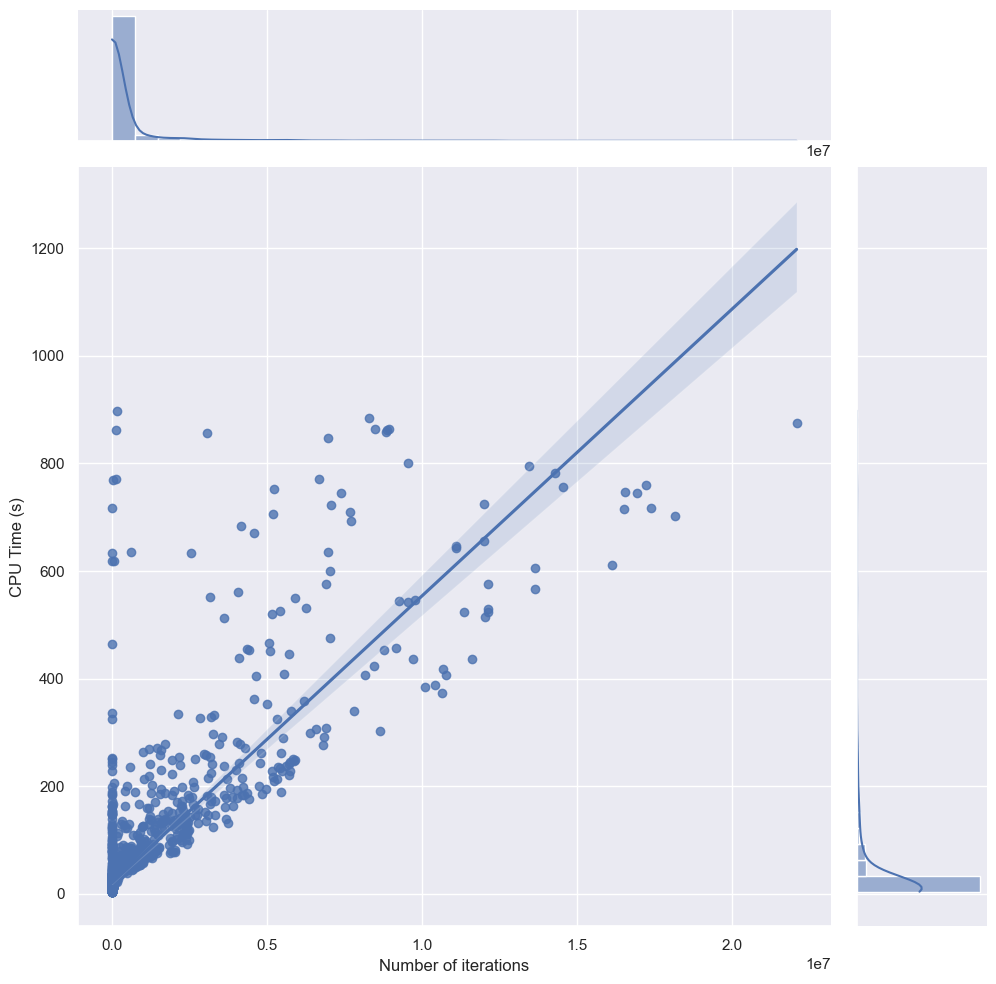

In [6]:
sns.jointplot(data=data_1, x="Number of iterations", y="CPU Time (s)", height=10, marginal_kws={"bins":30,}, kind="reg");

## 5-Fold Cross Validation

In [7]:
scores = cross_val_score(LR, x_sr.values.reshape(-1,1), y_sr.values, cv=5)
print("Mean r2 = %0.2f with a standard deviation of %0.2f:\nIndividual r2 values: %s" % (scores.mean(), scores.std(), scores))

Mean r2 = -13.48 with a standard deviation of 28.18:
Individual r2 values: [  0.78785148   0.58218299   0.60896076 -69.84601617   0.46400649]


# 2) Multiple Linear Regression: Manual Feature Selection

## Select metrics to analyze

In [8]:
data_in = data_clean.copy()

#Manually chosen features
data_2 = data_in[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of unique precision increments']]

#Drop rows that have NaN entries in chosen features
data_2 = data_2.dropna()

## Regression Pipeline

In [9]:
#CPU time is dependent variable
x_mr_df = data_2.drop(['CPU Time (s)'],axis=1)
y_mr_df = data_2['CPU Time (s)']
x_mr = x_mr_df.values
y_mr = y_mr_df.values

LR = LinearRegression()
pipeline = make_pipeline(StandardScaler(), LR)

## 5-Fold Cross Validation

In [10]:
scores = cross_val_score(pipeline, x_mr, y_mr, cv=5)
print("Mean r2 = %0.2f with a standard deviation of %0.2f:\nIndividual r2 values: %s" % (scores.mean(), scores.std(), scores))

Mean r2 = -1.07 with a standard deviation of 3.26:
Individual r2 values: [ 0.77468396  0.50903707  0.71639847 -7.57480248  0.20317295]


# 3) Multiple Linear Regression: Sequential Feature Selection

## Select metrics to analyze

In [11]:
data_in = data_clean.copy()

#Drop columns that are text: status, verdict (Unnamed: 1), Wall Time (s)
#Drop columns that are non-deterministic: Memory according to Martin
#Drop columns with discrete values: 'Number of target states'
data_3 = data_in.drop(['status','Unnamed: 1','Wall Time (s)','Automaton transfer successors','Memory (MB)','Number of target states'],axis=1,errors='ignore')

#Drop rows that have NaN entries in chosen features
data_3 = data_3.dropna()

## Regression Pipeline

In [12]:
#CPU time is dependent variable
x_mr_df = data_3.drop(['CPU Time (s)'],axis=1)
y_mr_df = data_3['CPU Time (s)']
x_mr = x_mr_df.values
y_mr = y_mr_df.values

LR =  LinearRegression()
pipeline = make_pipeline(StandardScaler(), LR)

## Sequential Feature Selection

In [13]:
sfs_forward = SequentialFeatureSelector(
    pipeline, n_features_to_select=5, direction="forward"
).fit(x_mr, y_mr)

feature_names = x_mr_df.columns.values
print(
    "Features selected by forward sequential selection:\n"
    f"{feature_names[sfs_forward.get_support()]}"
)

Features selected by forward sequential selection:
['Max size of waitlist' 'Number of unique precision increments'
 'Avg. size of reached set before ref.' 'Number of functions'
 'Number of reached locations']


## 5-Fold Cross Validation

In [14]:
x_selected = x_mr_df[feature_names[sfs_forward.get_support()]]
feature_names = x_selected.columns.values

scores = cross_val_score(pipeline, x_selected, y_mr, cv=5)
print("Mean r2 = %0.2f with a standard deviation of %0.2f:\nIndividual r2 values: %s" % (scores.mean(), scores.std(), scores))

Mean r2 = 0.54 with a standard deviation of 0.15:
Individual r2 values: [0.72016752 0.51497614 0.50793935 0.67497086 0.29355133]
